<font size=14>An exploration in creating an Enhanced Thresholding Analysis on NDWI for delineating Temporary Floodplain/Seasonal Wetlands as it pertains to Salmonid Habitat Quantification</font>

A restatement of our Problem and Possible Solutions

Problem: How to identify over a massive area temporary floodplain and seasonal wetland habitat possibly used by salmonids, without using biologists to manually survey the area and without manually labelling thousands of satellite images for habitat classes?

Technical Problem: How to create, validate, and deploy a scalable floodplain/wetland delineation system/tool that requires high resolution data in space and time using remote sensing (satellite imagery) and machine/deep learning?
    
Possible Solutions:  
1. Choose a different problem (genuinely, is this a problem that needs to be solved? has the problem been framed optimally?) 
2. Image Thresholding (traditional literature method -> prone to errors)  
3. Unsupervised Machine Learning (clustering -> unstable, limited reproducibility)  
4. Deep Learning (hype train -> significant hyperparameter optimization -> requires large labelled datasets)  
5. 42 (classical joke as the answer to life)

As you might imagine we are still on option #2, Image Thresholding and this notebook attempts to explore an enhanced methodology for removing the noise from previous NDWI Thresholding using threshold_minimum from skimage.filters. Please refer to notebooks 3, 4, 5 before continuing.

In [1]:
# Libraries needed for running this notebook
import numpy as np
import rasterio
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import skimage
from skimage.filters import threshold_minimum
from skimage import morphology
from skimage import measure
from skimage import segmentation

In [2]:
# NDVI is a remote sensing index or derived band from other bands that is particularly good at detecting vegetation (trees/fields)
def gen_NDVI(image_path):
    with rasterio.open(image_path) as ds:
        red_band3 = ds.read(3)
        nir_band4 = ds.read(4)
        np.seterr(divide='ignore', invalid='ignore')
        ndvi_array = ((nir_band4.astype(float) - red_band3.astype(float)) / (nir_band4.astype(float) + red_band3.astype(float)))
        ds.close()
    return ndvi_array

In [3]:
# NDWI is a remote sensing index or derived band from other bands that is particularly good at detecting water
def gen_NDWI(image_path):
    with rasterio.open(image_path) as ds:
        green_band2 = ds.read(2)
        nir_band4 = ds.read(4)
        np.seterr(divide='ignore', invalid='ignore')
        ndwi_array = ((green_band2.astype(float) - nir_band4.astype(float)) / (green_band2.astype(float) + nir_band4.astype(float)))
        ds.close()
    return ndwi_array

In [4]:
# load images from data folder
dry_img_path = "./intro_data/reflectance/20161011_final_mosaic.tif"
wet_img_path = "./intro_data/reflectance/20170228_final_mosaic.tif"
ndwi_dry_img = gen_NDWI(dry_img_path)
ndwi_wet_img = gen_NDWI(wet_img_path)
ndvi_dry_img = gen_NDVI(dry_img_path)
ndvi_wet_img = gen_NDVI(wet_img_path)
print('Image shape should all be equal')
print(ndwi_dry_img.shape, ndwi_wet_img.shape)
print(ndvi_dry_img.shape, ndvi_dry_img.shape)

Image shape should all be equal
(1334, 1334) (1334, 1334)
(1334, 1334) (1334, 1334)


In [5]:
# by default nan_to_num is setting No Data Values (NaN) as 0 which should have limited visual impact as NDWI and NDVI range from -1 to 1
ndwi_dry_img_display = np.nan_to_num(ndwi_dry_img)
ndwi_wet_img_display = np.nan_to_num(ndwi_wet_img)
ndwi_dry_histo = ndwi_dry_img[~np.isnan(ndwi_dry_img)]
ndwi_wet_histo = ndwi_wet_img[~np.isnan(ndwi_wet_img)]
assert ndwi_dry_img_display.shape == ndwi_wet_img_display.shape
total_img_pixels = ndwi_dry_img_display.shape[0]*ndwi_dry_img_display.shape[1]
print('Shape of NDWI Images for Display: {} | Total number of pixels: {}'.format(ndwi_dry_img_display.shape, total_img_pixels))
print('Number of non-NaN values in the NDWI Dry Histogram Array: {} | Removed {} NaN values'.format(ndwi_dry_histo.shape, total_img_pixels - ndwi_dry_histo.shape[0]))
print('Number of non-NaN values in the NDWI Wet Histogram Array: {} | Removed {} NaN values'.format(ndwi_wet_histo.shape, total_img_pixels - ndwi_wet_histo.shape[0]))
ndvi_dry_img_display = np.nan_to_num(ndvi_dry_img)
ndvi_wet_img_display = np.nan_to_num(ndvi_wet_img)
ndvi_dry_histo = ndvi_dry_img[~np.isnan(ndvi_dry_img)]
ndvi_wet_histo = ndvi_wet_img[~np.isnan(ndvi_wet_img)]
assert ndvi_dry_img_display.shape == ndvi_wet_img_display.shape
total_img_pixels = ndvi_dry_img_display.shape[0]*ndvi_dry_img_display.shape[1]
print('Shape of NDVI Images for Display: {} | Total number of pixels: {}'.format(ndvi_dry_img_display.shape, total_img_pixels))
print('Number of non-NaN values in the NDVI Dry Histogram Array: {} | Removed {} NaN values'.format(ndvi_dry_histo.shape, total_img_pixels - ndvi_dry_histo.shape[0]))
print('Number of non-NaN values in the NDVI Wet Histogram Array: {} | Removed {} NaN values'.format(ndvi_wet_histo.shape, total_img_pixels - ndvi_wet_histo.shape[0]))

Shape of NDWI Images for Display: (1334, 1334) | Total number of pixels: 1779556
Number of non-NaN values in the NDWI Dry Histogram Array: (1778888,) | Removed 668 NaN values
Number of non-NaN values in the NDWI Wet Histogram Array: (1778889,) | Removed 667 NaN values
Shape of NDVI Images for Display: (1334, 1334) | Total number of pixels: 1779556
Number of non-NaN values in the NDVI Dry Histogram Array: (1778888,) | Removed 668 NaN values
Number of non-NaN values in the NDVI Wet Histogram Array: (1778889,) | Removed 667 NaN values


Let's visualize our NDWI and NDVI Images and Histograms.

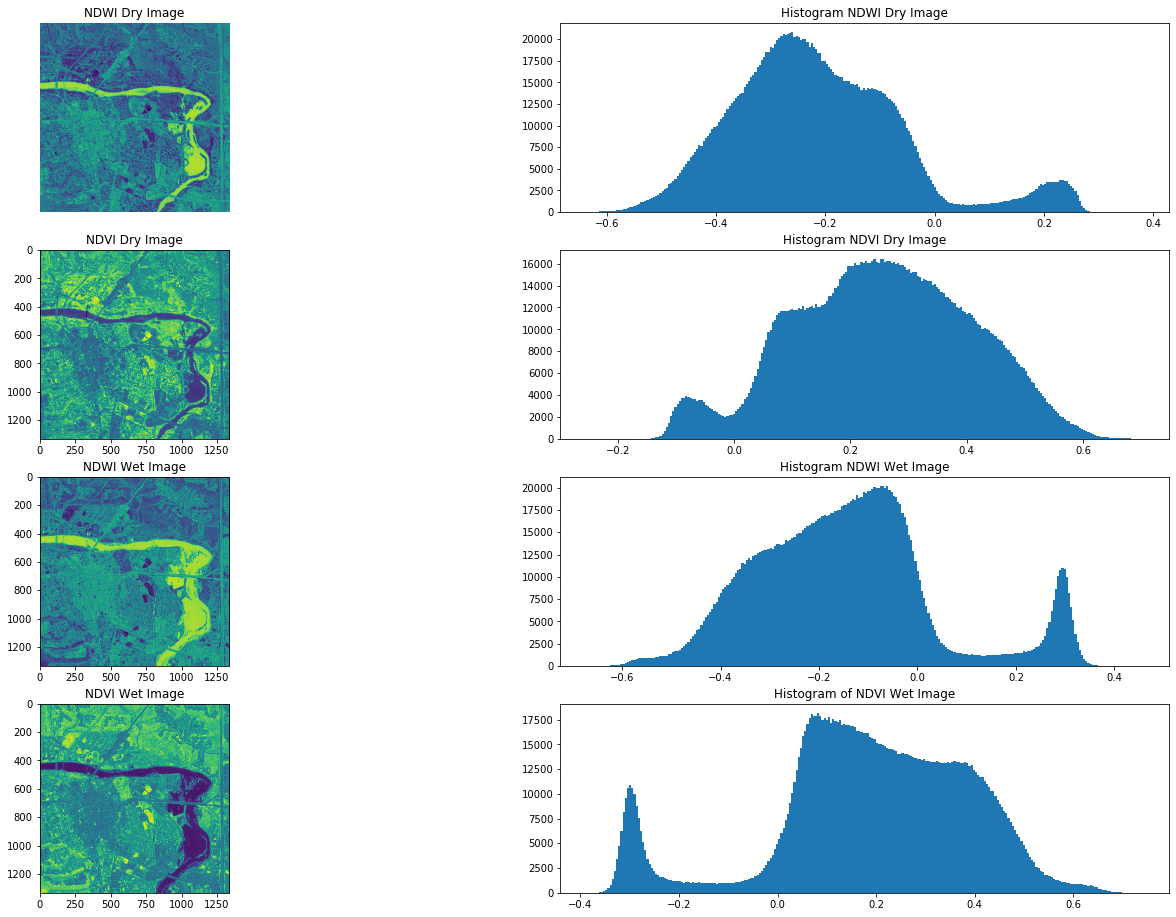

In [6]:
plt.figure(figsize=(24, 16))
plt.subplot(4, 2, 1)
plt.imshow(ndwi_dry_img_display, cmap=plt.cm.viridis)
plt.title('NDWI Dry Image')
plt.axis('off')

plt.subplot(4, 2, 2)
plt.hist(ndwi_dry_histo, bins=256)
plt.title('Histogram NDWI Dry Image')

plt.subplot(4, 2, 3)
plt.imshow(ndvi_dry_img_display, cmap=plt.cm.viridis)
plt.title('NDVI Dry Image')

plt.subplot(4, 2, 4)
plt.hist(ndvi_dry_histo, bins=256)
plt.title('Histogram NDVI Dry Image')

plt.subplot(4, 2, 5)
plt.imshow(ndwi_wet_img_display, cmap=plt.cm.viridis)
plt.title('NDWI Wet Image')

plt.subplot(4, 2, 6)
plt.hist(ndwi_wet_histo, bins=256)
plt.title('Histogram NDWI Wet Image')

plt.subplot(4, 2, 7)
plt.imshow(ndvi_wet_img_display, cmap=plt.cm.viridis)
plt.title('NDVI Wet Image')

plt.subplot(4, 2, 8)
plt.hist(ndvi_wet_histo, bins=256)
plt.title('Histogram of NDVI Wet Image')
plt.show()

In [7]:
thresh_ndwi_dry = threshold_minimum(ndwi_dry_histo)
thresh_ndwi_wet = threshold_minimum(ndwi_wet_histo)
thresh_ndvi_dry = threshold_minimum(ndvi_dry_histo)
thresh_ndvi_wet = threshold_minimum(ndvi_wet_histo)

print('Threshold for NDWI Dry and Wet Images, respectively: ', thresh_ndwi_dry, thresh_ndwi_wet)
print('Threshold for NDVI Dry and Wet Images, respectively: ', thresh_ndvi_dry, thresh_ndvi_wet)

# Why is ndwi > but ndvi is < ?
ndwi_dry_timg = ndwi_dry_img_display > thresh_ndwi_dry 
ndwi_wet_timg = ndwi_wet_img_display > thresh_ndwi_wet
ndvi_dry_timg = ndvi_dry_img_display < thresh_ndvi_dry
ndvi_wet_timg = ndvi_wet_img_display < thresh_ndvi_wet

Threshold for NDWI Dry and Wet Images, respectively:  0.06385960747514319 0.13656676891866876
Threshold for NDVI Dry and Wet Images, respectively:  -0.01907646213388281 -0.12793576931963602


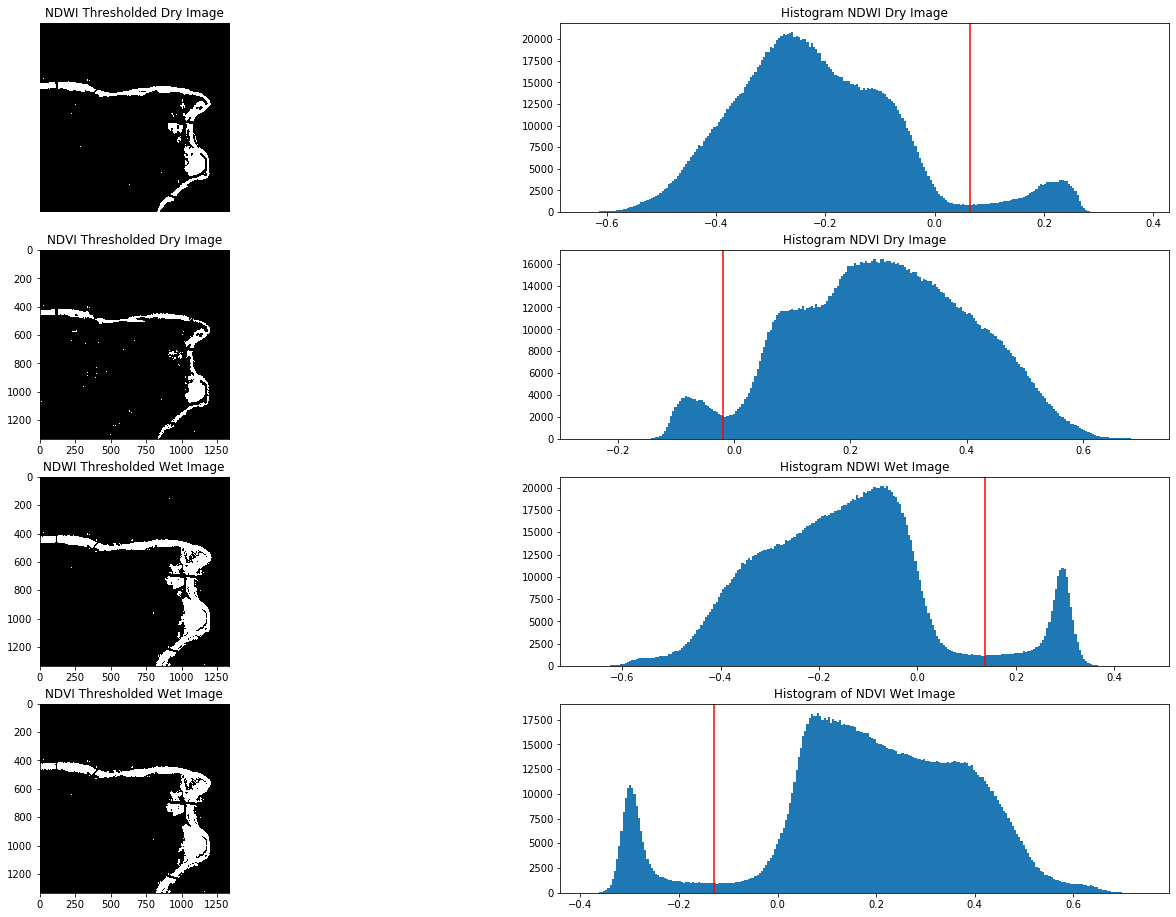

In [8]:
plt.figure(figsize=(24, 16))
plt.subplot(4, 2, 1)
plt.imshow(ndwi_dry_timg, cmap=plt.cm.gray)
plt.title('NDWI Thresholded Dry Image')
plt.axis('off')

plt.subplot(4, 2, 2)
plt.hist(ndwi_dry_histo, bins=256)
plt.axvline(thresh_ndwi_dry, color='r')
plt.title('Histogram NDWI Dry Image')

plt.subplot(4, 2, 3)
plt.imshow(ndvi_dry_timg, cmap=plt.cm.gray)
plt.title('NDVI Thresholded Dry Image')

plt.subplot(4, 2, 4)
plt.hist(ndvi_dry_histo, bins=256)
plt.axvline(thresh_ndvi_dry, color='r')
plt.title('Histogram NDVI Dry Image')

plt.subplot(4, 2, 5)
plt.imshow(ndwi_wet_timg, cmap=plt.cm.gray)
plt.title('NDWI Thresholded Wet Image')

plt.subplot(4, 2, 6)
plt.hist(ndwi_wet_histo, bins=256)
plt.axvline(thresh_ndwi_wet, color='r')
plt.title('Histogram NDWI Wet Image')

plt.subplot(4, 2, 7)
plt.imshow(ndvi_wet_timg, cmap=plt.cm.gray)
plt.title('NDVI Thresholded Wet Image')

plt.subplot(4, 2, 8)
plt.hist(ndvi_wet_histo, bins=256)
plt.axvline(thresh_ndvi_wet, color='r')
plt.title('Histogram of NDVI Wet Image')
plt.show()

Up to this point has been review of how the analysis obtains binary masked images of NDWI and NDVI. From this point on and enhanced analysis for removing noise from our thresholded binary images is explored.

Let's place our binary images into a Python dictionary so we can iterate on them later (i.e. for-loop).

In [9]:
binary_dict = {'NDWI': {'20161011': ndwi_dry_timg, '20170228': ndwi_wet_timg}, 'NDVI': {'20161011': ndvi_dry_timg, '20170228': ndvi_wet_timg}}
for k in binary_dict.keys():
    print('Binary dictionary keys: ', k)
    for k_inner in sorted(list(binary_dict.get(k).keys())):
        print('Inner binary dictionary keys: {} {}'.format(k, k_inner))

Binary dictionary keys:  NDWI
Inner binary dictionary keys: NDWI 20161011
Inner binary dictionary keys: NDWI 20170228
Binary dictionary keys:  NDVI
Inner binary dictionary keys: NDVI 20161011
Inner binary dictionary keys: NDVI 20170228


(1334, 1334, 2) (1334, 1334, 2)
(1334, 1334) (1334, 1334)


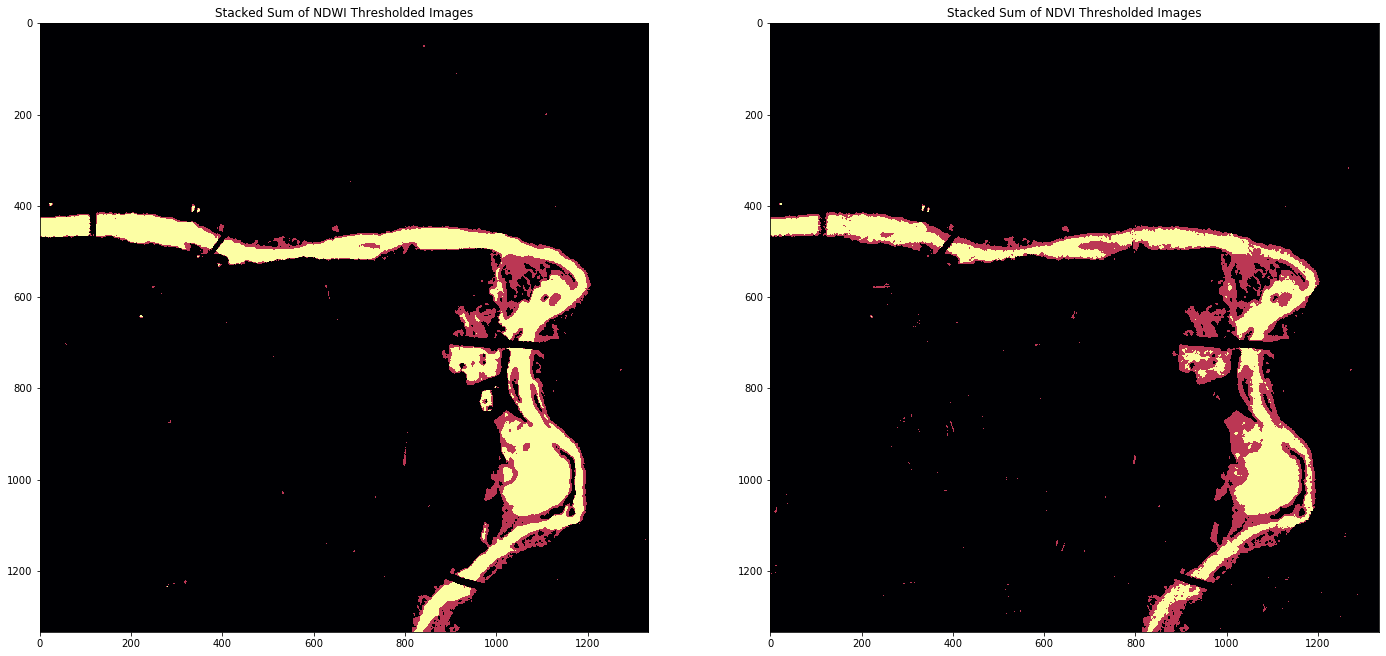

In [10]:
ndwi_stack = np.dstack(list(binary_dict.get('NDWI').values()))
ndvi_stack = np.dstack(list(binary_dict.get('NDVI').values()))
ndwi_sum_stack = np.sum(ndwi_stack, axis=2)
ndvi_sum_stack = np.sum(ndvi_stack, axis=2)
print(ndwi_stack.shape, ndvi_stack.shape)
print(ndwi_sum_stack.shape, ndvi_sum_stack.shape)

plt.figure(figsize=(24, 16))
plt.subplot(1, 2, 1)
plt.imshow(ndwi_sum_stack, cmap=plt.cm.inferno)
plt.title('Stacked Sum of NDWI Thresholded Images')

plt.subplot(1, 2, 2)
plt.imshow(ndvi_sum_stack, cmap=plt.cm.inferno)
plt.title('Stacked Sum of NDVI Thresholded Images')
plt.show()

Notice in the above images that as the stack for each Index (NDWI or NDVI) grows (i.e. more images, more temporal resolution), the amount of speckling noise also grows.<br>
Even more importantly, the speckling noise tends to end up with similiar numerical values as the "temporary floodplain/seasonal wetland".<br>
The enhanced analysis below aims at reducing this noise at a per time slice basis to prevent the additive growth of speckling noise, without degrading the rest of the result.

Let's start with the 2 NDWI Thresholded images.

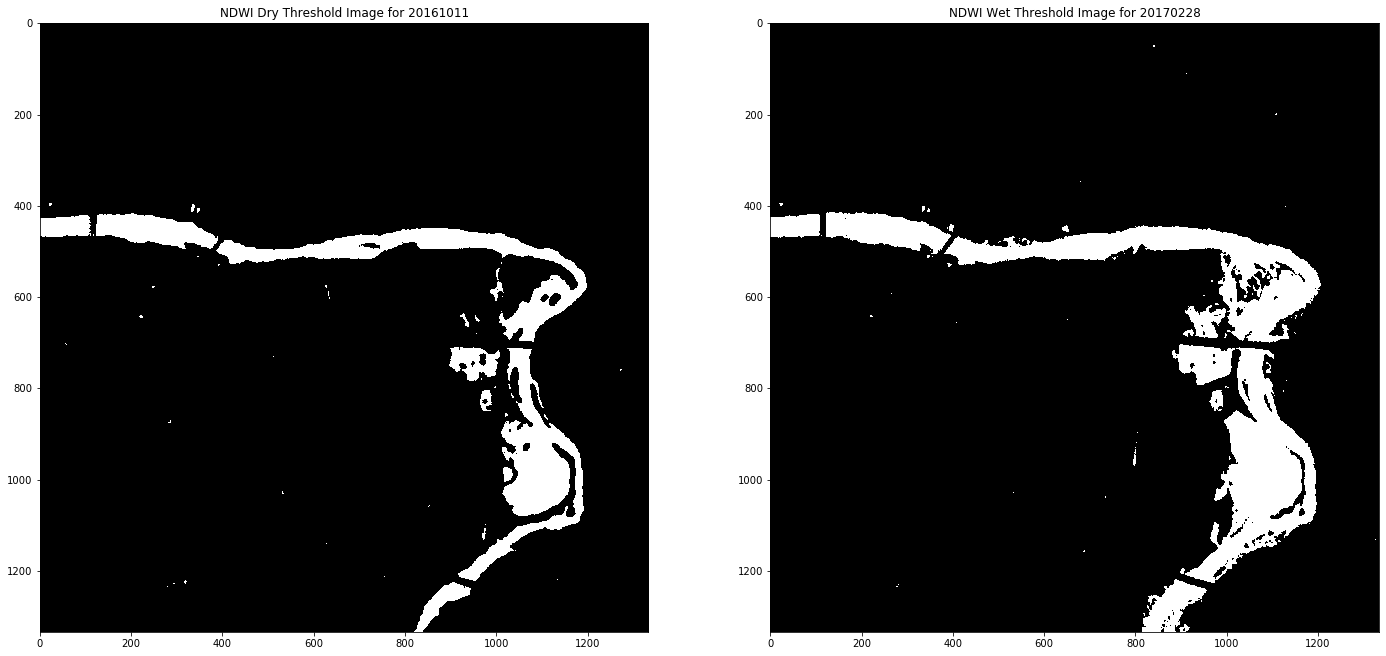

In [11]:
plt.figure(figsize=(24, 16))
plt.subplot(1, 2, 1)
plt.imshow(binary_dict.get('NDWI').get('20161011'), cmap=plt.cm.gray)
plt.title('NDWI Dry Threshold Image for 20161011')

plt.subplot(1, 2, 2)
plt.imshow(binary_dict.get('NDWI').get('20170228'), cmap=plt.cm.gray)
plt.title('NDWI Wet Threshold Image for 20170228')
plt.show()

Now instead of each pixel being a 0 or 1 value (i.e. True or False), what if the value of each pixel was the distance from the foreground to the background (i.e. what binary thresholding was originally designed to separate)? Then we would not have a binary image, but rather a distance landscape.

In [12]:
# this calculation uses euclidean distance, what other distance could be used?
ndwi_dry_distance = ndi.distance_transform_edt(binary_dict.get('NDWI').get('20161011'))
ndwi_wet_distance = ndi.distance_transform_edt(binary_dict.get('NDWI').get('20170228'))
print('Dry image max and min distance: ', np.max(ndwi_dry_distance), np.min(ndwi_dry_distance))
print('Wet image max and min distance: ', np.max(ndwi_wet_distance), np.min(ndwi_wet_distance))

Dry image max and min distance:  57.0350769263968 0.0
Wet image max and min distance:  72.89718787443039 0.0


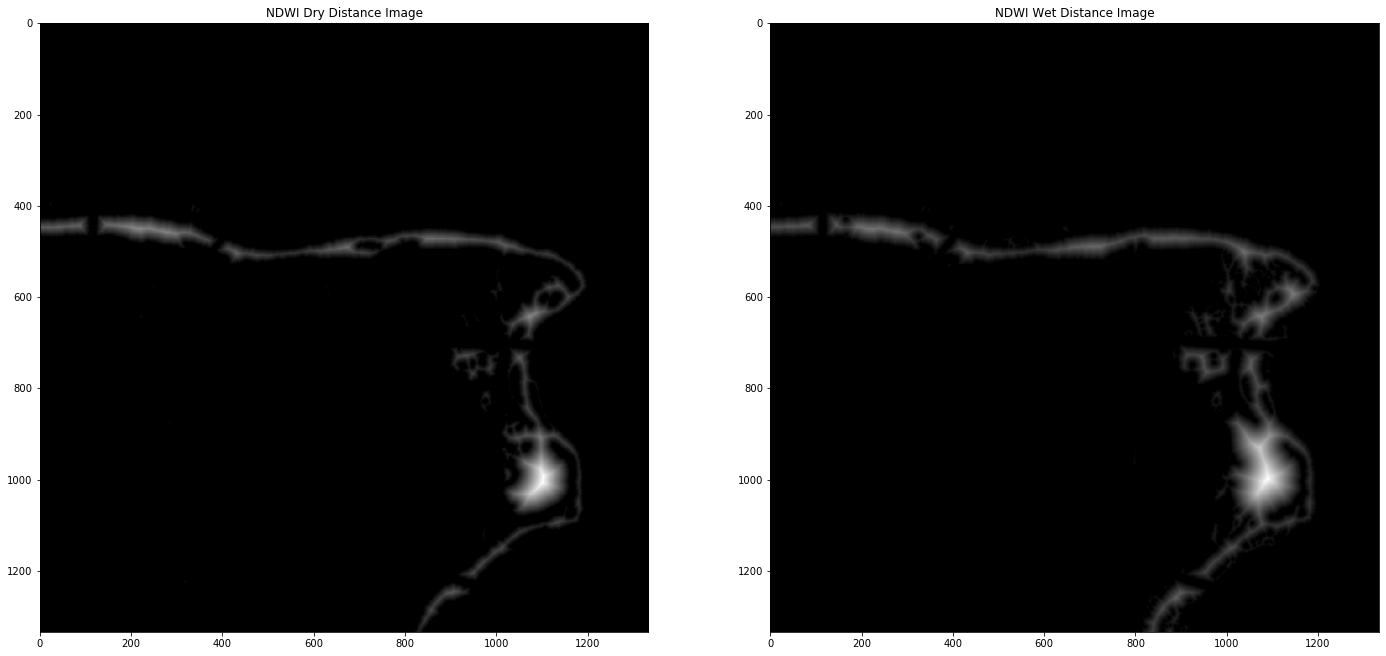

In [13]:
plt.figure(figsize=(24, 16))
plt.subplot(1, 2, 1)
plt.imshow(ndwi_dry_distance, cmap=plt.cm.gray)
plt.title('NDWI Dry Distance Image')

plt.subplot(1, 2, 2)
plt.imshow(ndwi_wet_distance, cmap=plt.cm.gray)
plt.title('NDWI Wet Distance Image')
plt.show()

But what if the distance image is visualized as a 3D landscape?

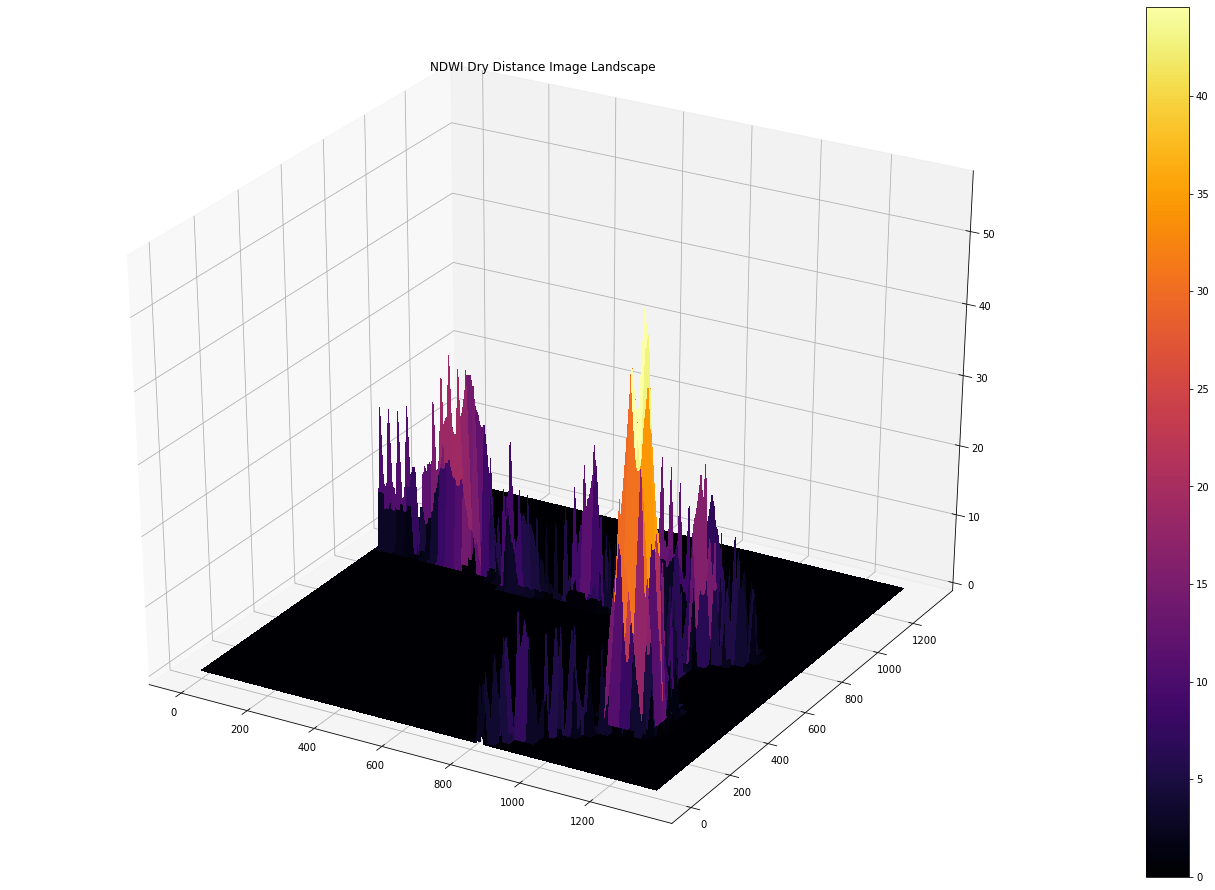

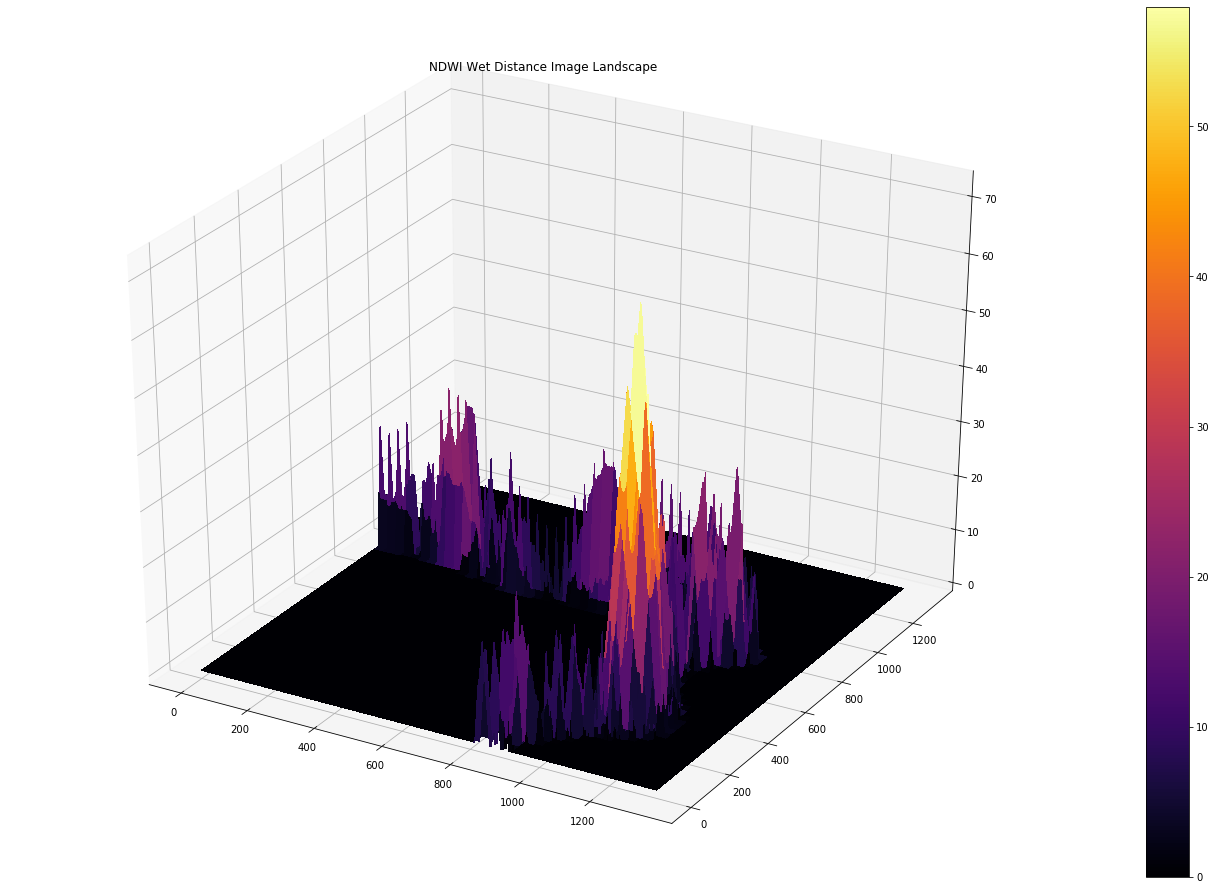

In [14]:
from mpl_toolkits.mplot3d import Axes3D
x = np.linspace(0, 1333, 1334)
y = np.linspace(0, 1333, 1334)
X1, Y1 = np.meshgrid(x, y[::-1])
Z1 = ndwi_dry_distance
Z2 = ndwi_wet_distance

fig = plt.figure(figsize=(24, 16))
ax = fig.gca(projection='3d')
ax.set_title('NDWI Dry Distance Image Landscape')
surf = ax.plot_surface(X1, Y1, Z1, cmap=plt.cm.inferno,
                        linewidth=0, antialiased=False)
fig.colorbar(surf)
plt.show()
fig = plt.figure(figsize=(24,16))
ax = fig.gca(projection='3d')
ax.set_title('NDWI Wet Distance Image Landscape')
surf = ax.plot_surface(X1, Y1, Z2, cmap=plt.cm.inferno,
                        linewidth=0, antialiased=False)
fig.colorbar(surf)
plt.show()

So imagine now that we want to determine all the local maxima in our landscape and visualize a point there (i.e. a point at each location where the distance is the highest in a predefined area around a pixel).

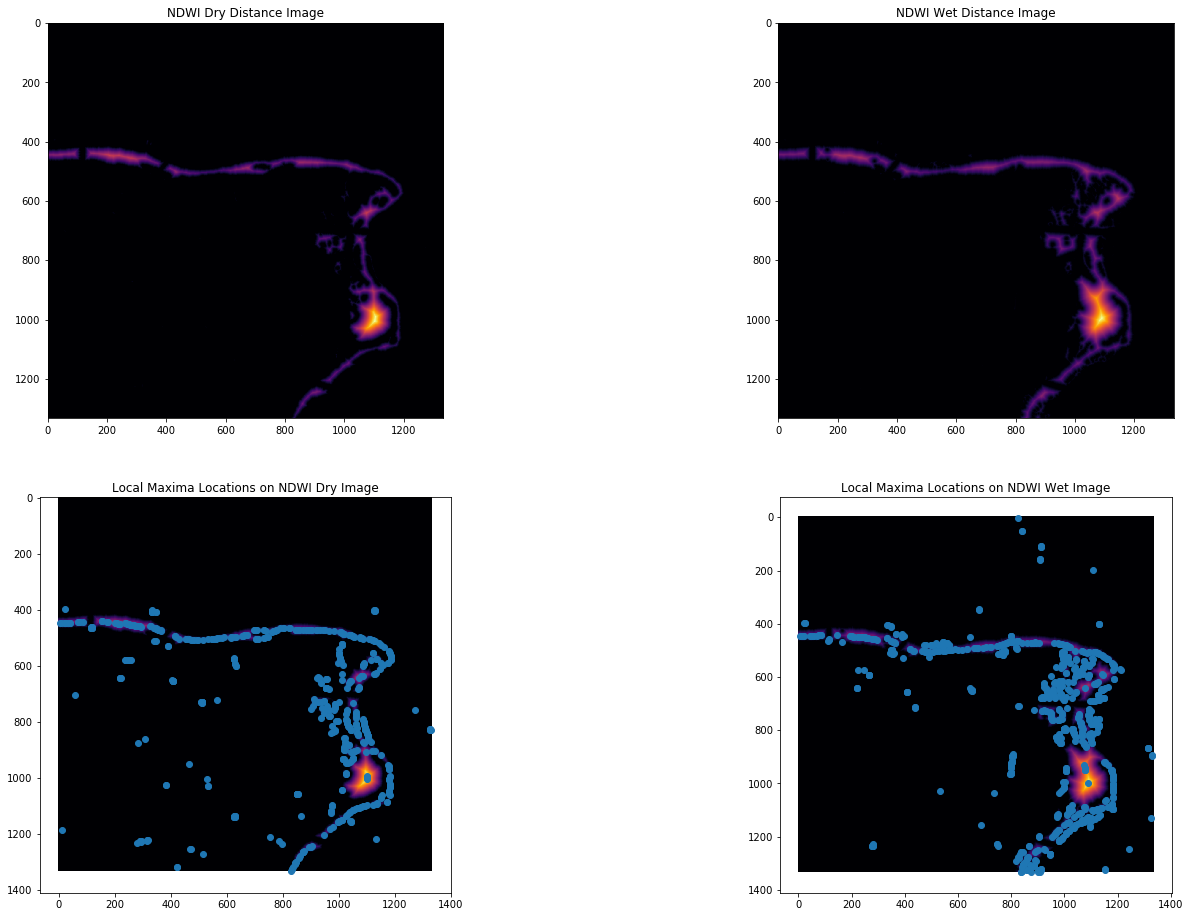

In [15]:
ndwi_dry_local_maxima = morphology.local_maxima(ndwi_dry_distance)
ndwi_wet_local_maxima = morphology.local_maxima(ndwi_wet_distance)
ndwi_dry_coors = np.nonzero(ndwi_dry_local_maxima)
ndwi_wet_coors = np.nonzero(ndwi_wet_local_maxima)

plt.figure(figsize=(24, 16))
plt.subplot(2, 2, 1)
plt.imshow(ndwi_dry_distance, cmap=plt.cm.inferno)
plt.title('NDWI Dry Distance Image')

plt.subplot(2, 2, 2)
plt.imshow(ndwi_wet_distance, cmap=plt.cm.inferno)
plt.title('NDWI Wet Distance Image')

plt.subplot(2, 2, 3)
plt.imshow(ndwi_dry_distance, cmap=plt.cm.inferno)
plt.scatter(ndwi_dry_coors[1], ndwi_dry_coors[0])
plt.title('Local Maxima Locations on NDWI Dry Image')

plt.subplot(2, 2, 4)
plt.imshow(ndwi_wet_distance, cmap=plt.cm.inferno)
plt.scatter(ndwi_wet_coors[1], ndwi_wet_coors[0])
plt.title('Local Maxima Locations on NDWI Wet Image')
plt.show()

Unfortunately, the local_maxima function has also placed a point in each of the noise regions as well (the small speckles) as they represent a local maxima. But what if we could say "only put a point where the maxima (or peaks) are H high"?<br>Introducing... **h_maxima**, where h is the minimum height required to place a point<br>

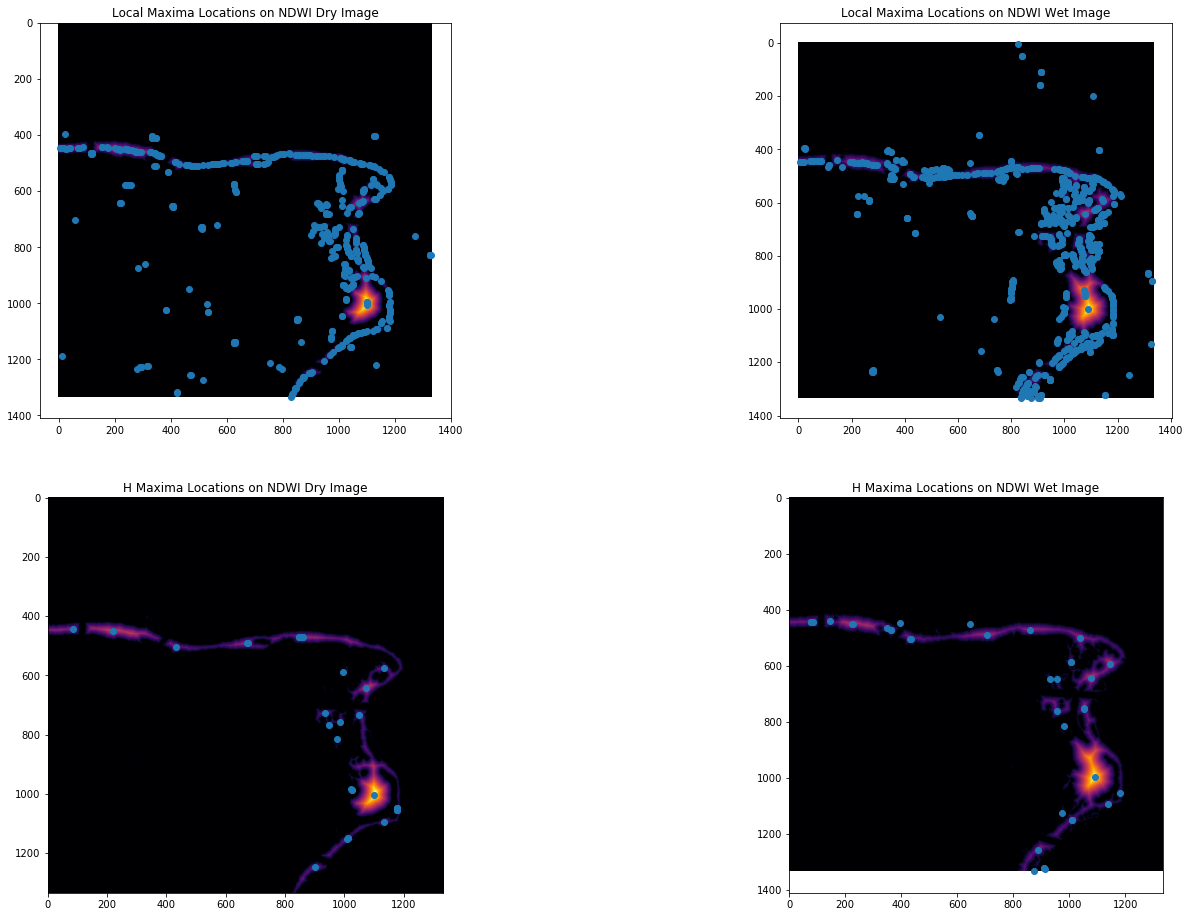

In [16]:
# what is the second argument 5 in h_maxima()?
ndwi_dry_h_maxima = morphology.extrema.h_maxima(ndwi_dry_distance, 5)
ndwi_wet_h_maxima = morphology.extrema.h_maxima(ndwi_wet_distance, 5)
ndwi_dry_hcoors = np.nonzero(ndwi_dry_h_maxima)
ndwi_wet_hcoors = np.nonzero(ndwi_wet_h_maxima)

plt.figure(figsize=(24, 16))
plt.subplot(2, 2, 1)
plt.imshow(ndwi_dry_distance, cmap=plt.cm.inferno)
plt.scatter(ndwi_dry_coors[1], ndwi_dry_coors[0])
plt.title('Local Maxima Locations on NDWI Dry Image')

plt.subplot(2, 2, 2)
plt.imshow(ndwi_wet_distance, cmap=plt.cm.inferno)
plt.scatter(ndwi_wet_coors[1], ndwi_wet_coors[0])
plt.title('Local Maxima Locations on NDWI Wet Image')

plt.subplot(2, 2, 3)
plt.imshow(ndwi_dry_distance, cmap=plt.cm.inferno)
plt.scatter(ndwi_dry_hcoors[1], ndwi_dry_hcoors[0])
plt.title('H Maxima Locations on NDWI Dry Image')

plt.subplot(2, 2, 4)
plt.imshow(ndwi_wet_distance, cmap=plt.cm.inferno)
plt.scatter(ndwi_wet_hcoors[1], ndwi_wet_hcoors[0])
plt.title('H Maxima Locations on NDWI Wet Image')
plt.show()

Amazingly, by putting a minimum height threshold in order to be considered a maxima, all the maxima for the speckle noise in our distance landscape images has been removed.<br>
But how would the user know to use a height of 5?<br>
Well remember that we created a euclidean distance landscape so all the user has to do is determine at what distance height is all the noise removed, which is directly related to how big (i.e. how many pixels?) all the speckle noise polygons were AND the user can be overly conservative.

So what? There are now maxima points at each place in the landscape that is furtherest from the background pixels...<br>
Well what if there was an algorithm that if the landscape was inverted we could fill each depression with water (i.e. each blue point becomes a water fountain) and segment the image?<br>
*cough* **watershed segmentation algorithm** *cough*

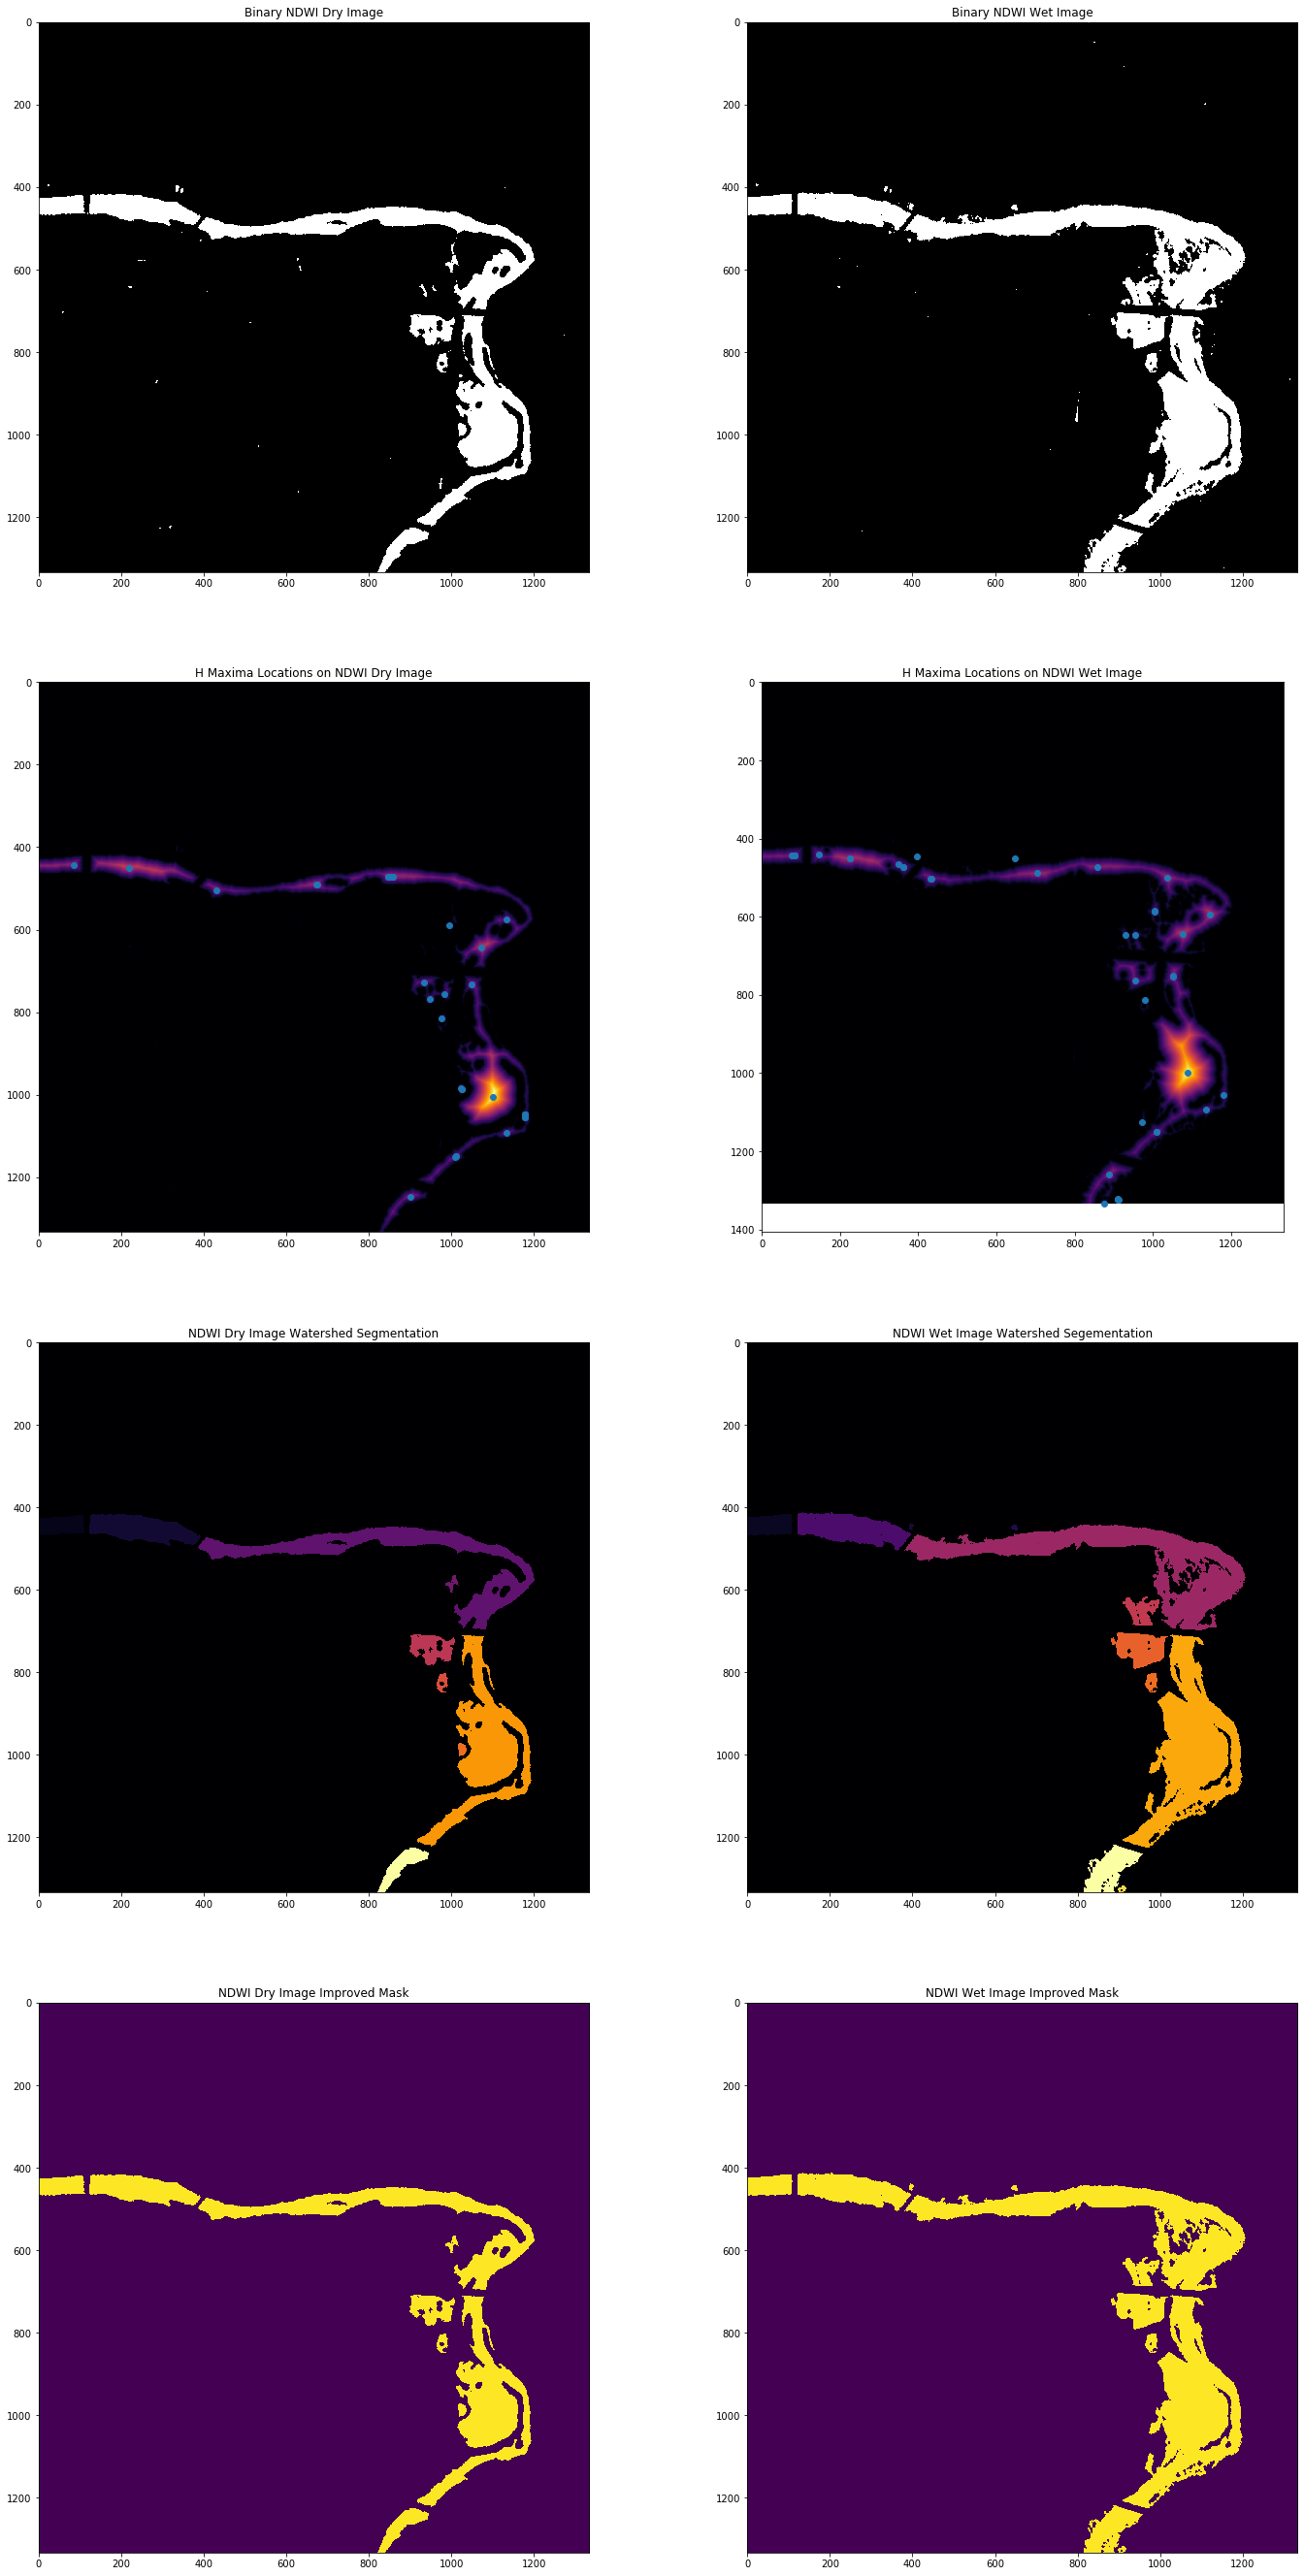

In [17]:
ndwi_dry_markers = ndi.label(ndwi_dry_h_maxima)[0]
ndwi_wet_markers = ndi.label(ndwi_wet_h_maxima)[0]
ndwi_dry_labels_masked = segmentation.watershed(ndwi_dry_distance, ndwi_dry_markers, mask=binary_dict.get('NDWI').get('20161011'))#, connectivity=2)
ndwi_wet_labels_masked = segmentation.watershed(ndwi_wet_distance, ndwi_wet_markers, mask=binary_dict.get('NDWI').get('20170228'))#, connectivity=2)
ndwi_dry_improved = np.where(ndwi_dry_labels_masked>0, 1, 0)
ndwi_wet_improved = np.where(ndwi_wet_labels_masked>0, 1, 0)


plt.figure(figsize=(24, 48))
plt.subplot(4, 2, 1)
plt.imshow(binary_dict.get('NDWI').get('20161011'), cmap=plt.cm.gray)
plt.title('Binary NDWI Dry Image')
plt.subplot(4, 2, 2)
plt.imshow(binary_dict.get('NDWI').get('20170228'), cmap=plt.cm.gray)
plt.title('Binary NDWI Wet Image')
plt.subplot(4, 2, 3)
plt.imshow(ndwi_dry_distance, cmap=plt.cm.inferno)
plt.scatter(ndwi_dry_hcoors[1], ndwi_dry_hcoors[0])
plt.title('H Maxima Locations on NDWI Dry Image')
plt.subplot(4, 2, 4)
plt.imshow(ndwi_wet_distance, cmap=plt.cm.inferno)
plt.scatter(ndwi_wet_hcoors[1], ndwi_wet_hcoors[0])
plt.title('H Maxima Locations on NDWI Wet Image')
plt.subplot(4, 2, 5)
plt.imshow(ndwi_dry_labels_masked, cmap=plt.cm.inferno)
plt.title('NDWI Dry Image Watershed Segmentation')
plt.subplot(4, 2, 6)
plt.imshow(ndwi_wet_labels_masked, cmap=plt.cm.inferno)
plt.title('NDWI Wet Image Watershed Segementation')
plt.subplot(4, 2, 7)
plt.imshow(ndwi_dry_improved)
plt.title('NDWI Dry Image Improved Mask')
plt.subplot(4, 2, 8)
plt.imshow(ndwi_wet_improved)
plt.title('NDWI Wet Image Improved Mask')
plt.show()

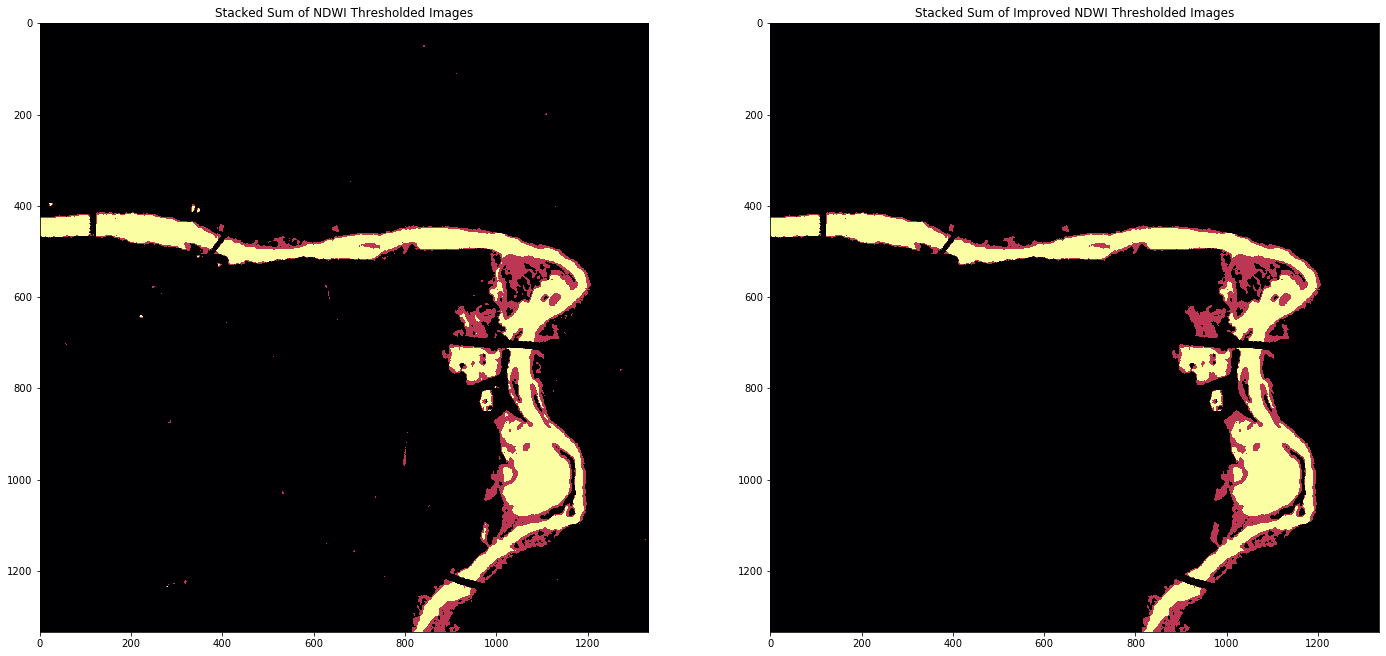

In [18]:
ndwi_improved_stack = np.dstack([ndwi_dry_improved, ndwi_wet_improved])
ndwi_improved_sum_stack = np.sum(ndwi_improved_stack, axis=2)

plt.figure(figsize=(24, 16))
plt.subplot(1, 2, 1)
plt.imshow(ndwi_sum_stack, cmap=plt.cm.inferno)
plt.title('Stacked Sum of NDWI Thresholded Images')

plt.subplot(1, 2, 2)
plt.imshow(ndwi_improved_sum_stack, cmap=plt.cm.inferno)
plt.title('Stacked Sum of Improved NDWI Thresholded Images')
plt.show()

In [19]:
def pixels_to_floodplain_acres(pixel_count):
    pixel_area = 3.1*3.1
    sq_meter_area = pixel_count*pixel_area
    floodplain_acres = sq_meter_area / 4046.856    
    return round(floodplain_acres, 2)

In [20]:
ndwi_orig_fpixels = (ndwi_sum_stack == 1).sum()
ndwi_improved_fpixels = (ndwi_improved_sum_stack == 1).sum()
diff_fpixels = ndwi_orig_fpixels - ndwi_improved_fpixels
print('Total Temporary Floodplain/Seasonal Wetland NDWI Original Pixel Count: {}'.format(ndwi_orig_fpixels))
print('Total Temporary Floodplain/Seasonal Wetland NDWI Improved Pixel Count: {}'.format(ndwi_improved_fpixels))
print('Difference: {}'.format(diff_fpixels))

Total Temporary Floodplain/Seasonal Wetland NDWI Original Pixel Count: 54591
Total Temporary Floodplain/Seasonal Wetland NDWI Improved Pixel Count: 53610
Difference: 981


In [21]:
orig_facres = pixels_to_floodplain_acres(ndwi_orig_fpixels)
improved_facres = pixels_to_floodplain_acres(ndwi_improved_fpixels)
difference_facres = pixels_to_floodplain_acres(diff_fpixels)
print('Total Temporary Floodplain/Seasonal Wetland NDWI Original: {}'.format(orig_facres))
print('Total Temporary Floodplain/Seasonal Wetland NDWI Improved: {}'.format(improved_facres))
print('Difference: {} acres'.format(difference_facres))

Total Temporary Floodplain/Seasonal Wetland NDWI Original: 129.64
Total Temporary Floodplain/Seasonal Wetland NDWI Improved: 127.31
Difference: 2.33 acres


While 2.33 acres may not seem like much, the following images show how much the additivie noise can build up too as the time-series of images increase for a given location.

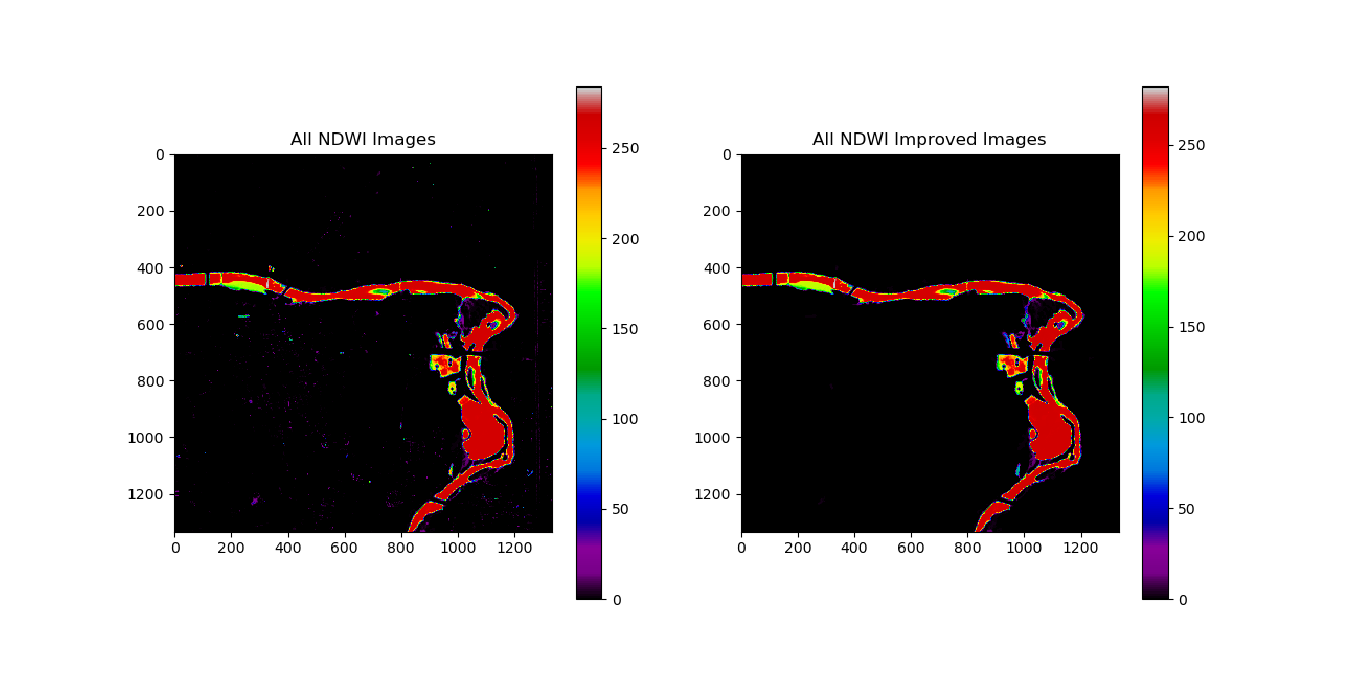

In [24]:
plt.figure(figsize=(24, 16))
img = plt.imread("./intro_data/ndwi_all_graphs_fornotebook.png")
plt.imshow(img)
plt.axis('off')
plt.show()